In [1]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import seaborn as sns
from operator import itemgetter
from skimage import io, transform
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, models
from torchmetrics import F1Score
from torchvision import transforms, utils, models
from torchsummary import summary

import torchbearer
from torchbearer import Trial, metrics, Metric
from torchbearer.callbacks import Best, ModelCheckpoint

import optuna
from optuna.samplers import TPESampler, RandomSampler

import ipywidgets
from tqdm import tqdm
import segmentation_models_pytorch as smp
import cv2

from PIL import Image

import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
class AdjacencyDataset(Dataset):
    """Apples Dataset"""

    def __init__(self, folders, lab=[0], test=False):
        """
        Args:
        """
        
        self.test=test
        self.data = np.vstack([np.loadtxt(f) for f in folders])
        self.lenghts = [len(np.loadtxt(f)) for f in folders]
        if not test:
            self.labels = np.concatenate([np.ones(self.lenghts[i])*l for i,l in enumerate(lab)])
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.test:
            return torch.from_numpy(self.data[idx]).type(torch.FloatTensor)
        else:
            return [torch.from_numpy(self.data[idx]).type(torch.FloatTensor), int(self.labels[idx])]
        

In [3]:
mydat = AdjacencyDataset(folders=["Files/MachineLearning/nonco.txt",
                                  "Files/MachineLearning/n1o.txt",
                                  "Files/MachineLearning/n2o.txt",
                                  "Files/MachineLearning/n3o.txt",
                                  "Files/MachineLearning/random.txt",
                                  "Files/MachineLearning/n5o.txt",
                                  "Files/MachineLearning/n6o.txt", 
                                  "Files/MachineLearning/o1n.txt"],
                         lab=[0,1,2,3,4,5,6,7],
                         test=False)

train_dim=int(len(mydat)*0.9)
val_dim=int(len(mydat)-train_dim)

mydat_train, mydat_val = random_split(mydat, [train_dim, val_dim])

train_dataloader = DataLoader(mydat_train, batch_size=10, shuffle=True, num_workers=0)
val_dataloader = DataLoader(mydat_val, batch_size=20, shuffle=False, num_workers=0)

In [4]:
mydat_test = AdjacencyDataset(folders=["Files/MachineLearning/n1s.txt", 
                                       "Files/MachineLearning/n1o1s.txt",
                                       "Files/MachineLearning/n2o1s.txt",
                                       "Files/MachineLearning/n3o1s.txt",
                                       "Files/MachineLearning/n4o1s.txt",
                                       ],
                              test=True)

test_dataloader = DataLoader(mydat_test, batch_size=10, shuffle=False, num_workers=0)

In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(in_features=15479, out_features=200)
        self.lin2 = nn.Linear(in_features=200, out_features=50)
        self.lin3 = nn.Linear(in_features=50, out_features=8)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

model = Model()
model=model.cpu()


In [10]:
check_best = Best('checkpoints/check_best.pth', monitor='val_acc', mode='max')
check_last = ModelCheckpoint('checkpoints/check_last.pth')

trial = Trial(model,
                 optim.Adam(model.parameters(), lr=5e-04), 
                 nn.CrossEntropyLoss(), 
                 metrics=["loss", "acc"],
                 callbacks=[check_best, check_last])

trial.load_state_dict(torch.load("checkpoints/check_best_0class.pth"))
print("net loaded")

net loaded


In [12]:
trial.with_generators(train_generator=train_dataloader, 
                          val_generator=val_dataloader, 
                          test_generator=test_dataloader)

#mytrial = trial.run()
mytrial = trial.run(epochs=74, verbose=1)

100%|##########| 74/74 [00:00<?, ?it/s]

100%|##########| 74/74 [00:00<?, ?it/s]

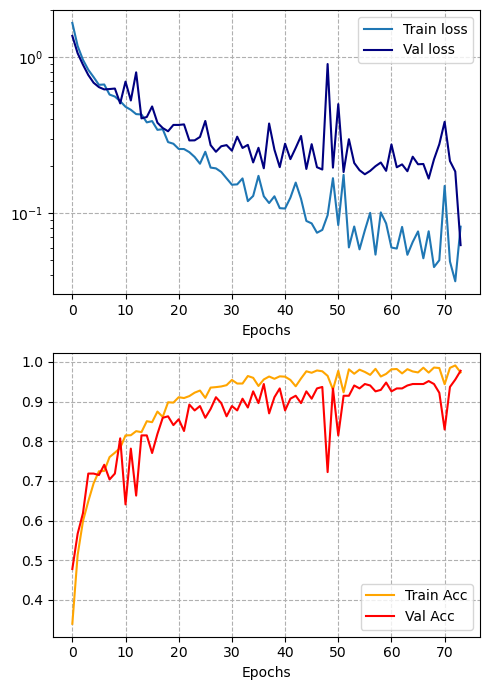

In [13]:
__, ax = plt.subplots(2,1,figsize=(5,7))

ax[0].semilogy([mt["loss"] for mt in mytrial], label="Train loss", color="C0")
ax[0].semilogy([mt["val_loss"] for mt in mytrial], label="Val loss", color="navy")

ax[1].plot([mt["acc"] for mt in mytrial], label="Train Acc", color="orange")
ax[1].plot([mt["val_acc"] for mt in mytrial], label="Val Acc", color="red")

[axi.set_xlabel("Epochs") for axi in ax]
[axi.legend() for axi in ax]
[axi.grid(ls="--") for axi in ax]

plt.tight_layout()

In [14]:
predicted_lab=np.argmax(trial.predict(),axis=1).detach().numpy()

74it [00:00, ?it/s]

0/1(p):   0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
trial.predict().detach().numpy()

74it [00:00, ?it/s]

0/1(p):   0%|          | 0/50 [00:00<?, ?it/s]

array([[  66.991005 ,   46.91552  ,   26.327566 , ..., -169.11978  ,
        -277.31015  , -367.08456  ],
       [  49.402164 ,   37.060898 ,   20.60561  , ..., -131.32974  ,
        -218.08606  , -289.8701   ],
       [  61.920643 ,   44.7238   ,   25.145082 , ..., -159.4754   ,
        -263.22495  , -350.14676  ],
       ...,
       [ -24.258877 ,   -7.609163 ,    3.1533566, ...,  -47.69067  ,
         -87.54909  , -122.31704  ],
       [ -36.421207 ,  -23.542395 ,   -6.142934 , ...,  -33.027756 ,
         -65.4409   , -100.6639   ],
       [ -30.641468 ,  -12.099226 ,    1.0636925, ...,  -44.891083 ,
         -84.51767  , -122.97745  ]], dtype=float32)

In [36]:
print("Nonco+Sars: \t\t%.2f±%.2f" %(np.mean(predicted_lab[0:100]), np.std(predicted_lab[0:100])))
print("Nonco+Onco+Sars: \t%.2f±%.2f" %(np.mean(predicted_lab[100:200]), np.std(predicted_lab[100:200])))
print("Nonco+2Onco+Sars: \t%.2f±%.2f" %(np.mean(predicted_lab[200:300]), np.std(predicted_lab[200:300])))
print("Nonco+3Onco+Sars: \t%.2f±%.2f" %(np.mean(predicted_lab[300:400]), np.std(predicted_lab[300:400])))

Nonco+Sars: 		0.02±0.14
Nonco+Onco+Sars: 	0.65±0.48
Nonco+2Onco+Sars: 	1.10±0.30
Nonco+3Onco+Sars: 	1.72±0.49


In [15]:
val_dim

270

0/1(p):   0%|          | 0/14 [00:00<?, ?it/s]

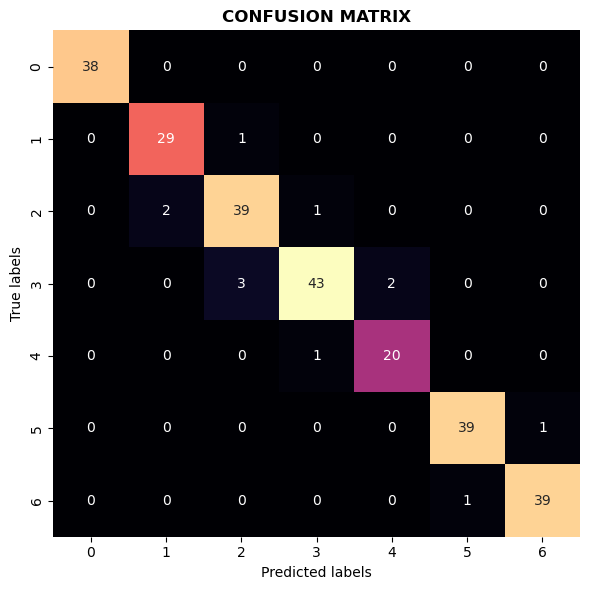

In [34]:
val_pred=np.argmax(trial.predict(data_key=torchbearer.VALIDATION_DATA).detach().numpy(),axis=1)
val_true=[v[1] for v in val_dataloader.dataset]

confM_val = confusion_matrix(y_true = val_true, y_pred = val_pred, labels=np.arange(7))

plt.figure(figsize=(6,6))
sns.heatmap(confM_val, annot=True, fmt="g", cbar=False, cmap="magma")
plt.title("CONFUSION MATRIX", weight="bold")
plt.ylabel("True labels")
plt.xlabel("Predicted labels")
plt.tight_layout()

In [ ]:
folders=["Files/MachineLearning/nonco.txt",
                                  "Files/MachineLearning/n1o.txt",
                                  "Files/MachineLearning/n2o.txt",
                                  "Files/MachineLearning/n3o.txt",
                                  "Files/MachineLearning/random.txt",
                                  "Files/MachineLearning/n5o.txt",
                                  "Files/MachineLearning/n6o.txt", 
                                  "Files/MachineLearning/o1n.txt"]
trainn = np.vstack([np.loadtxt(f) for f in folders])
lenghts = [len(np.loadtxt(f)) for f in folders]
labels = np.concatenate([np.ones(lenghts[i])*l for i,l in enumerate([0,1,2,3,4,5,6,7])])

In [25]:
reddim_val = trial.predict(data_key=torchbearer.VALIDATION_DATA).detach().numpy()
reddim_test = trial.predict().detach().numpy()
val_true=[v[1] for v in val_dataloader.dataset]

74it [00:00, ?it/s]

0/1(p):   0%|          | 0/14 [00:00<?, ?it/s]

74it [00:00, ?it/s]

0/1(p):   0%|          | 0/50 [00:00<?, ?it/s]

In [33]:
reddim_pred.shape

(270, 8)

In [32]:
np.vstack([reddim_pred, reddim_test]).shape

(770, 8)

In [51]:
sklearn.externals.joblib

AttributeError: module 'sklearn.externals' has no attribute 'joblib'

In [55]:
from sklearn.decomposition import PCA
import numpy as np

# Fit PCA on the data
pca = PCA(n_components=2)
pca.fit(reddim_pred)

# Transform new data using the fitted PCA
pca_val = pca.transform(reddim_val)
pca_test = pca.transform(reddim_pred)

In [54]:
from sklearn.manifold import TSNE

import joblib
# Fit the TSNE model on the training data
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(np.vstack([reddim_pred, reddim_test]))

# Save the TSNE model using joblib
joblib.dump(tsne, 'tsne_model.pkl')

# Load the TSNE model from file
tsne = joblib.load('tsne_model.pkl')

# Transform new samples using the loaded TSNE model
X_tsne_new = tsne.transform(reddim_test)

AttributeError: 'TSNE' object has no attribute 'transform'

<Axes: >

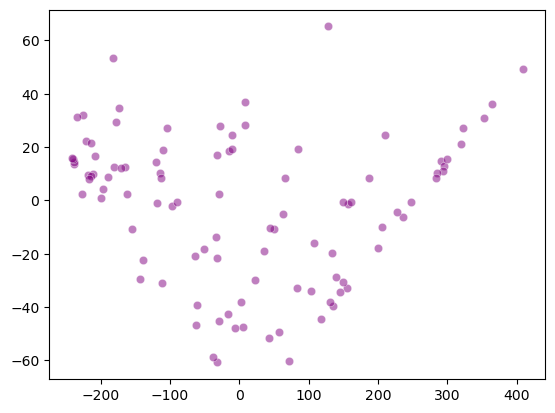

In [73]:
from sklearn import manifold

transf = manifold.TSNE(2, perplexity=15, early_exaggeration=7)
trasformatoo = transf.fit_transform(np.vstack([reddim_pred, reddim_test]))
#teat_transf = transf.fit_transform(reddim_test)
#sns.scatterplot(pca_val[:,0], pca_val[:,1], hue=val_true, palette="Set1")
sns.scatterplot(pca_test[:100,0], pca_test[:100,1], alpha=0.5, color="purple")


In [44]:
import umap

umap = umap.UMAP(2)
transkkk=umap.fit_transform(np.vstack([reddim_pred, reddim_test]))

<Axes: >

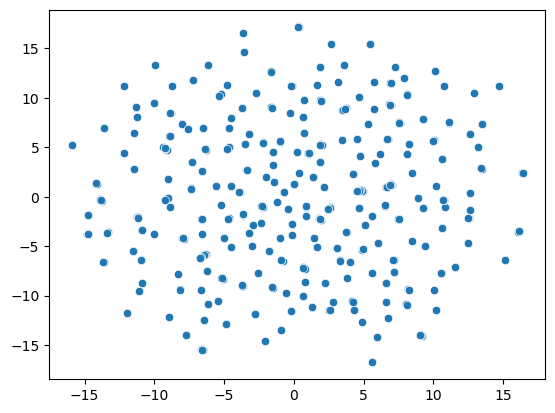

In [45]:
sns.scatterplot(transkkk[:,0], transkkk[:,1])#, hue=labels, palette="Set1")